In [1]:
import sys
import os
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

numpyro.set_host_device_count(
    2
)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)
#jax.config.update('jax_disable_jit', True)

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner

from jax0planet.light_curve import legacy_oblate_lightcurve, compute_bounds
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


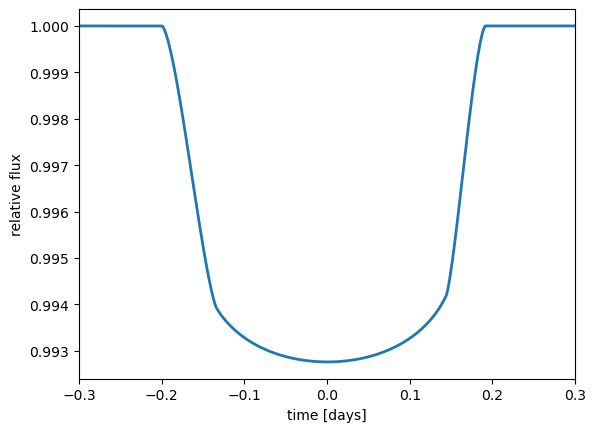

In [2]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'f':0.3,
          'bo':0.7,
          'theta':jnp.radians(35),
          'duration': 0.4
}
# The light curve calculation requires an orbit

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)
oblate_lightcurve = jit(legacy_oblate_lightcurve)
lc = oblate_lightcurve(params,t)

plt.plot(t, lc, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

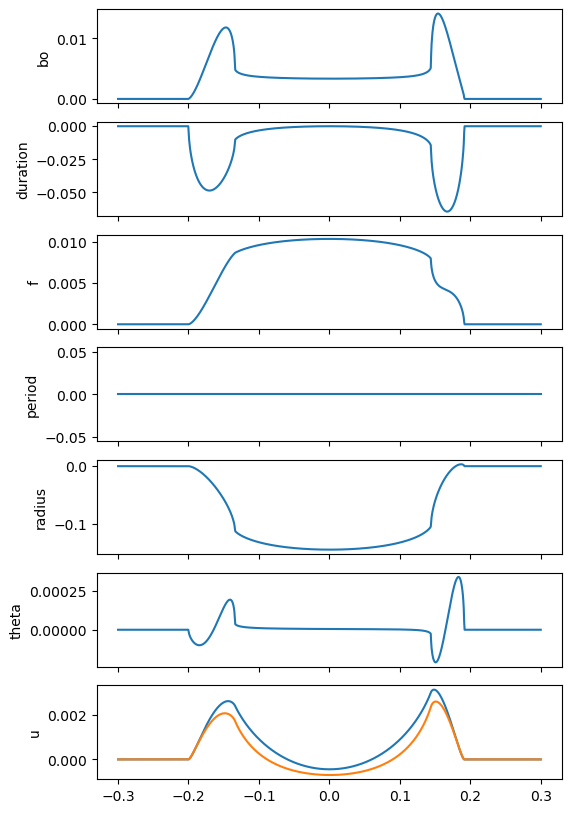

In [3]:
grad = jax.jacrev(oblate_lightcurve)
grads = grad(params, t)
_, axes = plt.subplots(len(grads.keys()), 1, figsize=(6, 10), sharex=True)
for n, key in enumerate(grads.keys()):
    axes[n].plot(t, grads[key])
    axes[n].set_ylabel(key)

{'period': 7.704045333151538, 't0': 1.0, 'radius': 0.1, 'bo': 0.8, 'u': Array([0.3, 0.2], dtype=float64), 'f': 0.3, 'theta': 0.6108652381980153, 'duration': 0.12}


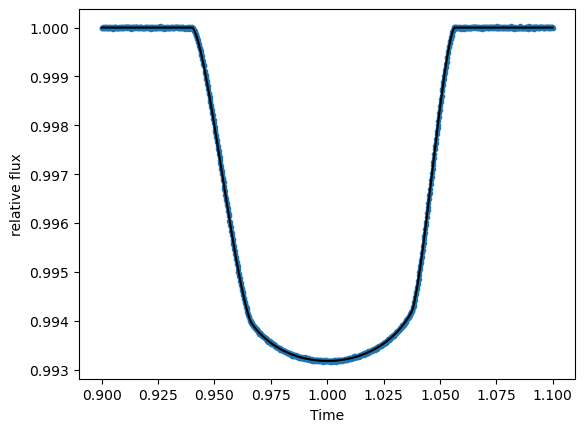

In [4]:
np.random.seed(11)
period_true = np.random.uniform(5, 20)
t = np.linspace(0.9,1.1,1000)
yerr = 10*1e-6

true_params = {'period':period_true,
               't0':1.0,
                'radius':0.1,
                'bo':0.8,
                'u':jnp.array([0.3, 0.2]),
                'f':0.3,
                'theta':np.radians(35),
                'duration': 0.12
} 

print(true_params)

# Compute a limb-darkened light curve using starry
lc_true = oblate_lightcurve(true_params, t-true_params['t0'])

lc = lc_true + yerr*np.random.normal(size=len(t))

ax = plt.subplot()
ax.plot(t, lc, 'C0.')
ax.plot(t, lc_true, color='k')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time");

In [18]:
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    #log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    r_circ = numpyro.sample("r_circ", dist.Uniform(0.01, 0.2))
    u = numpyro.sample("u", distx.QuadLDParams())
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.))
    
    #parametrize f, theta using a unit disk
    hk = numpyro.sample("hk", distx.UnitDisk())
    f = numpyro.deterministic("f", hk[0] ** 2 + hk[1] ** 2)
    theta = numpyro.deterministic("theta", jnp.arctan2(hk[1], hk[0])/2)
    
    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(0.12), 0.1))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    
    params = {
        'period':period_true,
        't0': 1.0,
        "radius": jnp.sqrt(r_circ**2/(1-f)),
        'bo':bo,
        'u': u,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    y_pred = oblate_lightcurve(params, t-params['t0'])
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample(
        "flux",
        dist.Normal(y_pred, jnp.sqrt(yerr**2) #+ jnp.exp(2 * log_jitter))
                    ),
        obs=y,
    )

In [19]:
n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), t, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

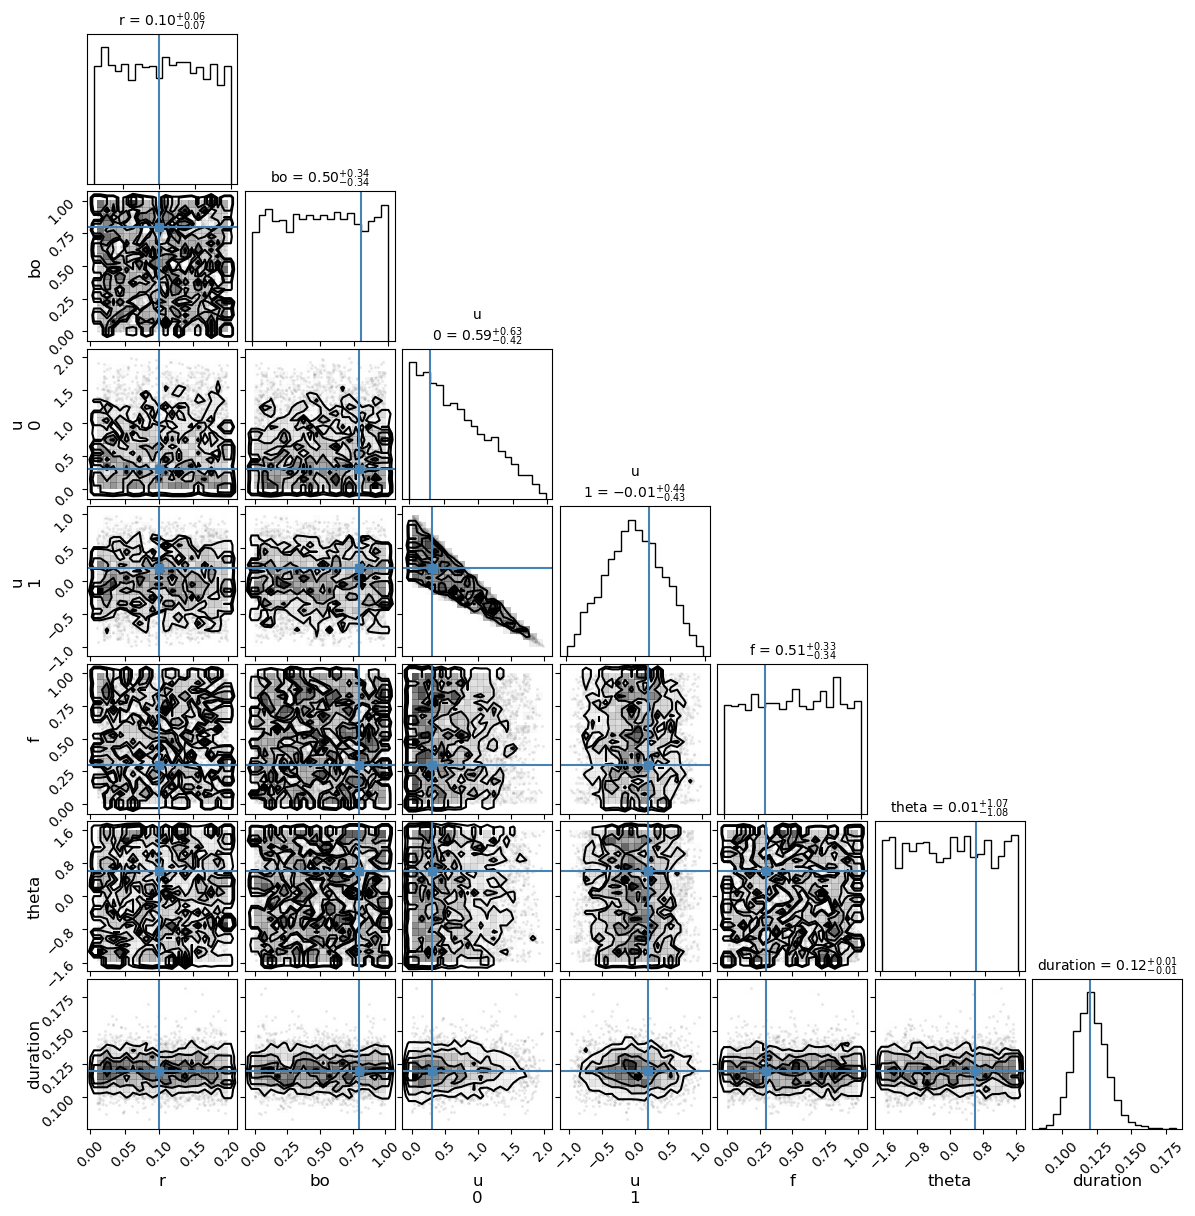

In [20]:
# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'],
    truths=[true_params['radius'], true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 12},
)

### Oblate MCMC Fit

In [21]:
init_params = {'period':period_true,
                't0':1.0,
                'log_jitter':np.log(yerr),
                'r':true_params['radius'],
                'u':jnp.array([0.3, 0.2]),
                'f':0.1,
                'bo':0.79,
                'theta':jnp.radians(20),
                'log_d': jnp.log(0.12),
                'hk':jnp.array([jnp.sqrt(0.1)*jnp.sin(jnp.radians(20)), jnp.sqrt(0.1)*jnp.cos(jnp.radians(20))])
               
}

In [22]:
import numpyro_ext.distributions, numpyro_ext.optim

run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

opt_params = run_optim(jax.random.PRNGKey(5), t, yerr, y=lc)

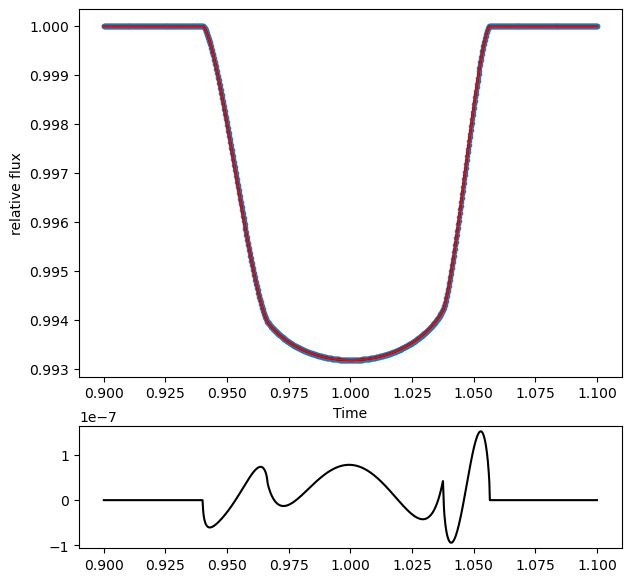

In [23]:
fig, (ax, ax1) = plt.subplots(2,1,figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]})
ax.plot(t, lc, 'C0.')
ax.plot(t, lc_true, color='k')
ax.plot(t,opt_params['light_curve'], color='r')
ax1.plot(t, lc_true-opt_params['light_curve'], 'k-')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time");

In [25]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.8,
        dense_mass=True,
        init_strategy=infer.init_to_value(values=opt_params),
        regularize_mass_matrix=False,
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, lc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 1h 56min 36s, sys: 25.1 s, total: 1h 57min 1s
Wall time: 1h 24min 36s


In [26]:
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.100,0.000,0.100,0.100,0.0,0.0,1158.0,1409.0,1.0
bo,0.800,0.000,0.800,0.800,0.0,0.0,1187.0,1478.0,1.0
u[0],0.301,0.001,0.299,0.302,0.0,0.0,1349.0,1520.0,1.0
u[1],0.199,0.001,0.198,0.201,0.0,0.0,1358.0,1520.0,1.0
f,0.300,0.000,0.300,0.300,0.0,0.0,1120.0,1270.0,1.0
theta,0.611,0.001,0.609,0.612,0.0,0.0,1036.0,1168.0,1.0
duration,0.120,0.000,0.120,0.120,0.0,0.0,1063.0,1198.0,1.0


In [27]:
sampler_wn.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        bo      0.80      0.00      0.80      0.80      0.80   1178.84      1.00
     hk[0]      0.19      0.00      0.19      0.19      0.19   1027.90      1.00
     hk[1]      0.51      0.00      0.51      0.51      0.51   1010.42      1.00
     log_d     -2.12      0.00     -2.12     -2.12     -2.12   1053.82      1.00
         r      0.10      0.00      0.10      0.10      0.10   1149.72      1.00
      u[0]      0.30      0.00      0.30      0.30      0.30   1345.23      1.00
      u[1]      0.20      0.00      0.20      0.20      0.20   1350.80      1.00

Number of divergences: 2558


array([[<AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'r'}>],
       [<AxesSubplot:title={'center':'bo'}>,
        <AxesSubplot:title={'center':'bo'}>],
       [<AxesSubplot:title={'center':'u'}>,
        <AxesSubplot:title={'center':'u'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

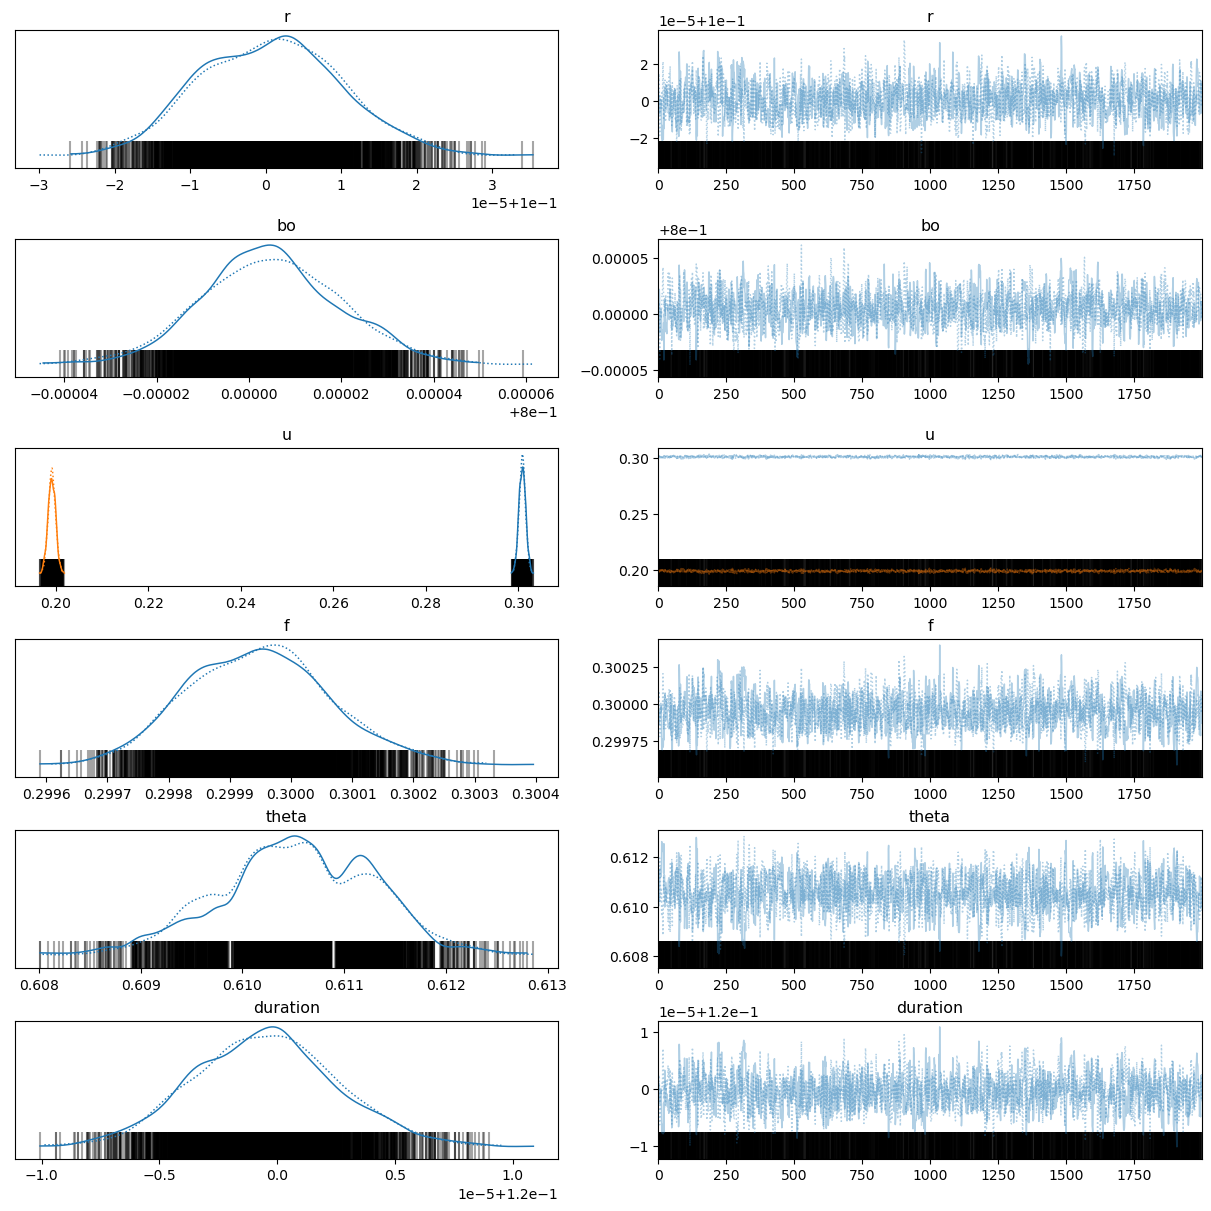

In [28]:
az.plot_trace(
    inf_data_wn,
    var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'],
    backend_kwargs={"constrained_layout": True},
)

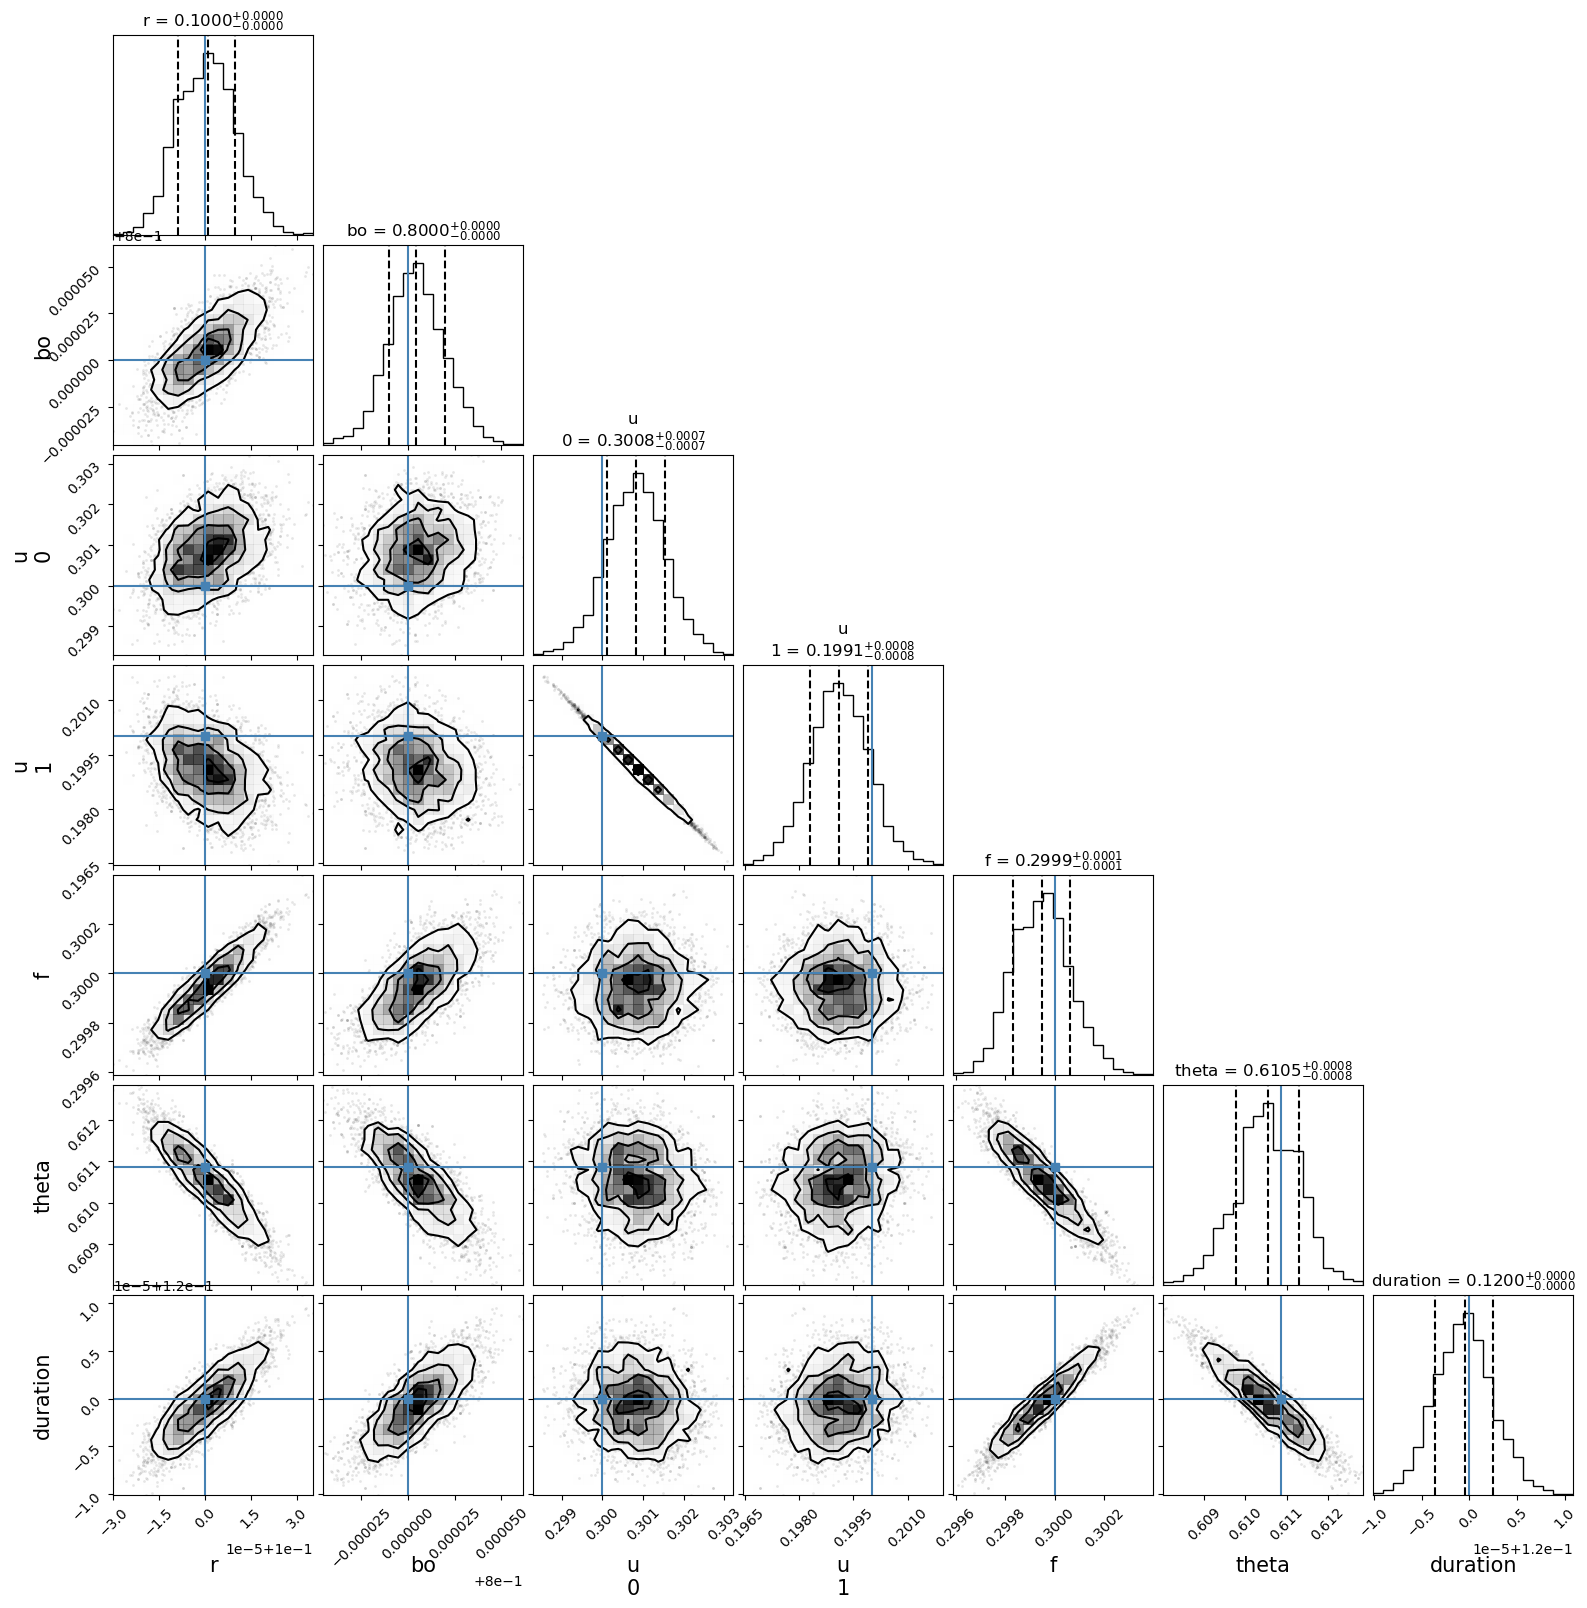

In [29]:
corner.corner(
    inf_data_wn,
    var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'],
    truths=[true_params['radius'], true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15},
    title_fmt=".4f",
);

In [4]:
import jax.numpy as jnp
jnp.radians(35)
jnp.degrees(0.575)

Array(32.945072, dtype=float32, weak_type=True)

### Oblate Nested Sampling Fit

In [ ]:
from numpyro.contrib.nested_sampling import NestedSampler
from jaxns.prior_transforms.prior import UniformBase

In [ ]:
ns = NestedSampler(model,constructor_kwargs={'num_parallel_samplers':40})
ns.run(jax.random.PRNGKey(2), t, yerr, lc)

ns_samples = ns.get_samples(jax.random.PRNGKey(121), num_samples=10000)

In [15]:
inf_data = az.from_dict(ns_samples, dropna=True)
az.summary(inf_data, var_names=["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"])


arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_jitter,-1.694,0.0,-1.694,-1.694,0.0,0.0,10000.0,10000.0,NaN
log_r,0.553,0.0,0.553,0.553,0.0,0.0,9757.0,9561.0,NaN
u1,0.304,0.0,0.304,0.304,0.0,0.0,9786.0,9360.0,NaN
u2,0.079,0.0,0.079,0.079,0.0,0.0,9785.0,9568.0,NaN
bo,0.446,0.0,0.446,0.446,0.0,0.0,9577.0,9541.0,NaN
f,0.243,0.0,0.243,0.243,0.0,0.0,9651.0,9631.0,NaN
theta,1.869,0.0,1.869,1.869,0.0,0.0,10239.0,10077.0,NaN


In [21]:
import matplotlib as mpl
def plot_corner_diagnostics(samples, param_true):
    mpl.rcParams['font.size'] = 12
    ndim = len(samples.keys())
    # This is the empirical mean of the sample:
    value2 = np.mean(np.array(list(samples.values())),axis=1)
    #True
    value1 = param_true

    # Make the base corner plot
    # 68% et 95% quantiles 1D et levels in 2D
    figure = corner.corner(samples,quantiles=(0.025, 0.158655, 0.841345, 0.975), levels=(0.68,0.95), 
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        truths=param_true, truth_color='g', color='b'
                        );

    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value2[i], color="r")
    
    # Loop over the histograms
    for idy in range(ndim):
        for idx in range(idy):
            ax = axes[idy, idx]
            ax.axvline(value2[idx], color="r")
            ax.axhline(value2[idy], color="r")
            ax.plot(value2[idx], value2[idy], "sr")

    plt.show()

In [34]:
flat_samples = []
truth_list = []
for i,v in enumerate(varnames):
    flat_samples_i = ns_samples[v]
    flat_samples.append(flat_samples_i)
flat_samples = np.array(flat_samples)


WARNING[2023-10-16 14:51:10,564]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,590]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,610]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,635]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,651]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,665]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,687]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,703]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,718]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,732]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,756]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,771]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,786]: Too few points to create valid contours
WARNING[2023-10-16 14:51:10,801]: Too 

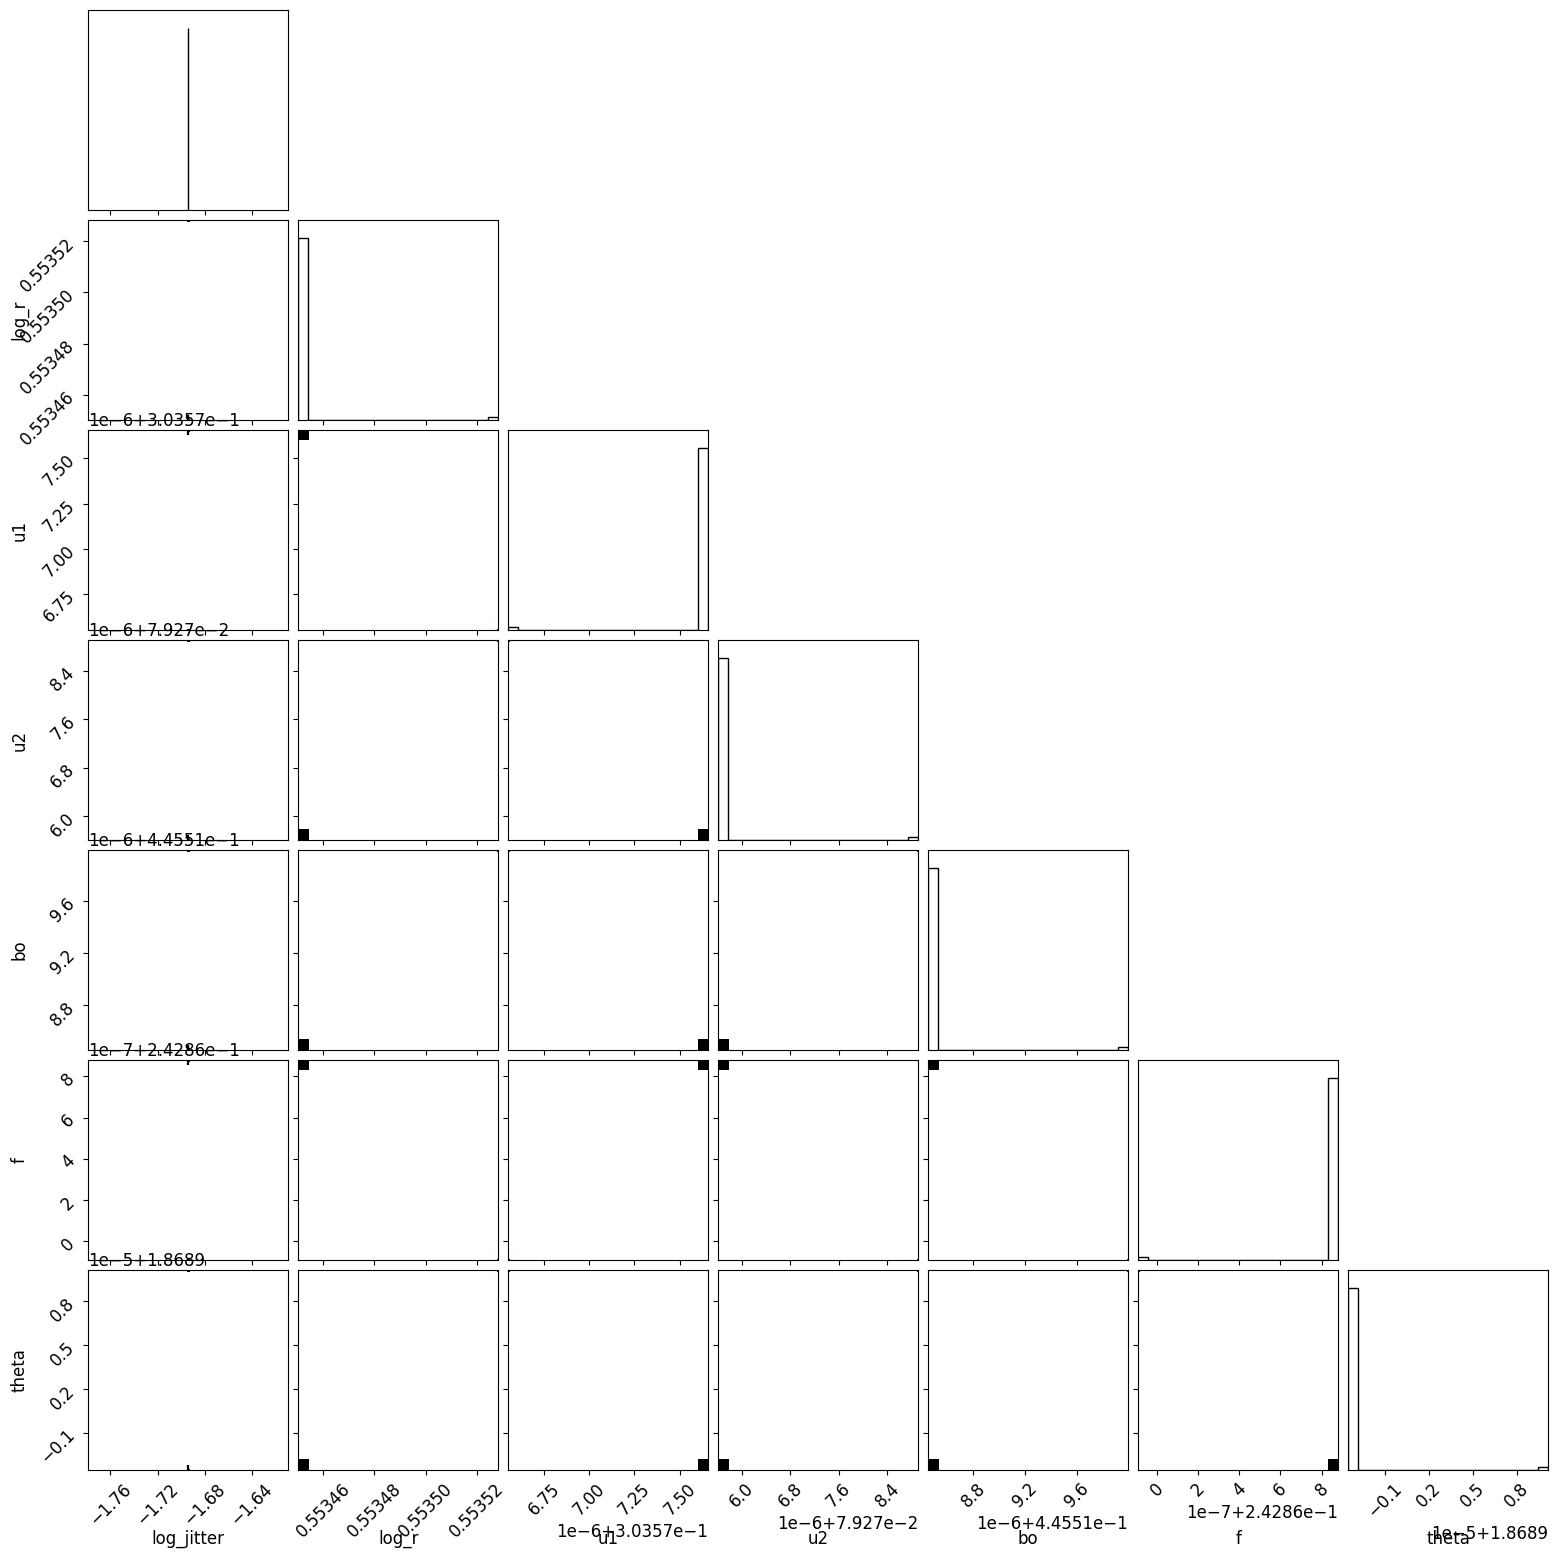

In [47]:
import corner
varnames = ["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"]
fig = corner.corner(flat_samples.T,range=[0.001,1,1,1,1,1,1],labels=varnames,truth=[yerr,jnp.log(true_params['radius']),true_params['u'][0],true_params['u'][1],true_params['bo'],true_params['f'],true_params['theta']])
plt.savefig('oblate_corner.png')

In [55]:
[yerr,jnp.log(true_params['radius']),true_params['u'][0],true_params['u'][1],true_params['bo'],true_params['f'],true_params['theta']]
np.degrees(np.mean(flat_samples.T[:,6]))

107.07989312215959